In [130]:
# detailed_response_analysis.ipynb
# Avery Krieger 07/27/2023

# this allows you to edit src code and run 
# (the alternative is to restart the kernel EVERY time you make a change to src...BAD)
%load_ext autoreload
%autoreload 2

from visanalysis.analysis import imaging_data, shared_analysis
from visanalysis.util import plot_tools

from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy import stats
from scipy.stats import wilcoxon
import pingouin as pg

import os
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from statannotations.Annotator import Annotator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading dataframe from pickle

Also establishing the paths for saving

In [152]:
save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/detailed_response/" #+ experiment_file_name + "/"
save_directory2 = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/flash_w_opto_step/" #+ experiment_file_name + "/"

Path(save_directory).mkdir(exist_ok=True)

exp_control_rnai_advanced_by_roi = pd.read_pickle(save_directory2 + 'exp_control_rnai_advanced_by_roi_v3.pkl') # exp_control_rnai_advanced_by_roi_v2 exp_control_rnai_advanced_by_roi

## Subselect from the big DF

We want:
- Proximal layer
- Window 0

In [132]:
# get the correct dataframe set up
which_df_placeholder = exp_control_rnai_advanced_by_roi
# copy, don't just set equal. Then combine the opto intensities 1 and 2
prox_win0_df = which_df_placeholder.loc[(which_df_placeholder['Layer'] == 'Proximal') & (which_df_placeholder['Window'] == 0)]

prox_win0_df

,ROI,Layer,PtT_Ratio,Pos_Integral,Neg_Integral,Integral_Ratio,Peak_Index,Trough_Index,Opto,Window,Type
567,0,Proximal,-1.846835,1.054219,1.518556,0.694225,5.0,11.0,0,0,experimental
571,0,Proximal,-3.360493,1.189797,1.091585,1.089972,5.0,12.0,1,0,experimental
575,0,Proximal,-3.881904,1.297149,1.467819,0.883726,5.0,12.0,2,0,experimental
579,1,Proximal,-6.591914,3.116575,1.156910,2.693878,5.0,13.0,0,0,experimental
583,1,Proximal,-7.637634,3.402545,1.210181,2.811600,5.0,12.0,1,0,experimental
...,...,...,...,...,...,...,...,...,...,...,...
337,15,Proximal,-7.274765,2.652167,1.009831,2.626347,4.0,11.0,1,0,RNAi
341,15,Proximal,-6.401968,2.961629,1.009007,2.935193,3.0,10.0,2,0,RNAi
345,16,Proximal,-7.041479,2.741385,0.923825,2.967429,3.0,10.0,0,0,RNAi
349,16,Proximal,-6.890939,2.743799,0.971176,2.825235,3.0,10.0,1,0,RNAi


# Violin Plots

First, violin plots for Experimental, Control, and RNAi conditions. Then, just Control and RNAi (for visualizations). 

The metrics to plot are: "PtT_Ratio", "Pos_Integral", "Neg_Integral", "Integral_Ratio", "Peak_Index", "Trough_Index"
- Peak-to-Trough Ratio
- Positive Integral value
- Negative Integral (absolute value)
- Integral Ratio
- Peak Index (index where peak occurs; proxy for tau)
- Trough Index

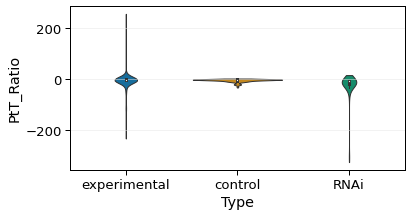

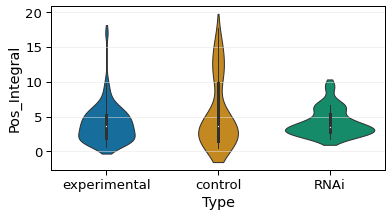

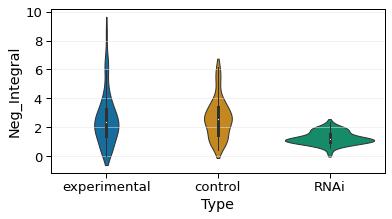

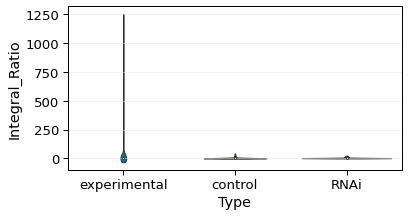

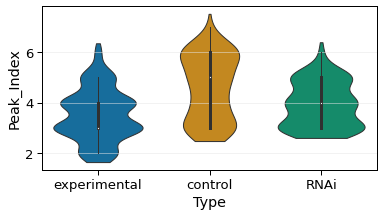

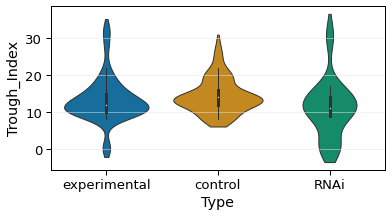

In [151]:
# Rapidly plot some metrics - 
save_fig = True
dv_set = ["PtT_Ratio", "Pos_Integral", "Neg_Integral", "Integral_Ratio", "Peak_Index", "Trough_Index"] 
win_set = [0, 1, 2]
type_set = ['experimental', 'control', 'RNAi']

for dv in dv_set:
    sns.set_context("paper", font_scale=1.5)
    comp_fig, comp_ax = plt.subplots(1, figsize=(6, 3))
    # Now, make the violinplot of the ROIs
    sns.violinplot(
        ax=comp_ax, data=prox_win0_df, x='Type', y=dv, 
        palette='colorblind', orient='v', linewidth=1,
        cut=1,
    )
    comp_ax.grid(axis="y", color="0.9", linestyle="-", linewidth=1, alpha=0.5)
    if save_fig == True:
        comp_fig.savefig(save_directory + dv + '_by_type.png', dpi=300, bbox_inches='tight')
        comp_fig.savefig(save_directory + dv + '_by_type.svg', dpi=300, bbox_inches='tight')


Getting just the control and rnai conditions into a df

In [144]:
prox_win0_con = prox_win0_df.loc[(prox_win0_df['Type'] == 'control')]
prox_win0_rnai = prox_win0_df.loc[(prox_win0_df['Type'] == 'RNAi')]
# concatenate the two df
prox_win0_con_rnai = pd.concat([prox_win0_con, prox_win0_rnai])
prox_win0_con_rnai

,ROI,Layer,PtT_Ratio,Pos_Integral,Neg_Integral,Integral_Ratio,Peak_Index,Trough_Index,Opto,Window,Type
243,0,Proximal,-6.187824,5.540077,1.200096,4.616362,5.0,15.0,0,0,control
247,0,Proximal,-5.653972,4.960087,1.325025,3.743390,6.0,16.0,1,0,control
251,0,Proximal,-4.040335,4.347349,1.502104,2.894173,6.0,15.0,2,0,control
255,1,Proximal,-2.580714,3.578792,3.499009,1.022802,6.0,14.0,0,0,control
259,1,Proximal,-4.124945,4.614409,2.601857,1.773506,6.0,13.0,1,0,control
...,...,...,...,...,...,...,...,...,...,...,...
337,15,Proximal,-7.274765,2.652167,1.009831,2.626347,4.0,11.0,1,0,RNAi
341,15,Proximal,-6.401968,2.961629,1.009007,2.935193,3.0,10.0,2,0,RNAi
345,16,Proximal,-7.041479,2.741385,0.923825,2.967429,3.0,10.0,0,0,RNAi
349,16,Proximal,-6.890939,2.743799,0.971176,2.825235,3.0,10.0,1,0,RNAi


Just the control and RNAi conditions, now

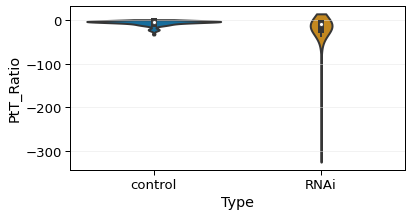

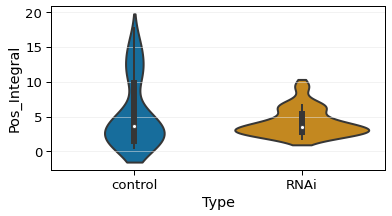

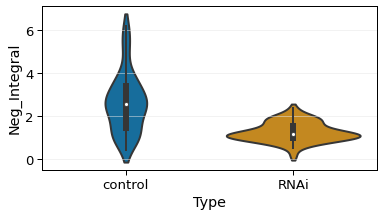

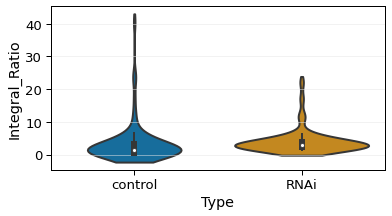

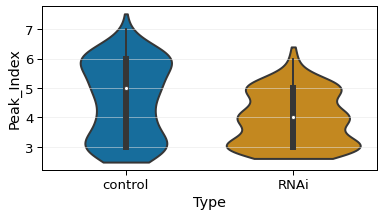

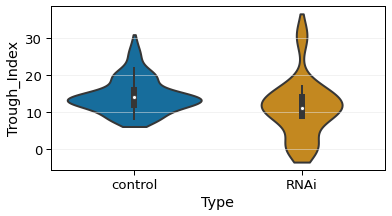

In [150]:
save_fig = True
dv_set = ["PtT_Ratio", "Pos_Integral", "Neg_Integral", "Integral_Ratio", "Peak_Index", "Trough_Index"] 
win_set = [0, 1, 2]
type_set = ['control', 'RNAi']

for dv in dv_set:
    sns.set_context("paper", font_scale=1.5)
    comp_fig, comp_ax = plt.subplots(1, figsize=(6, 3))
    # Now, make the violinplot of the ROIs
    sns.violinplot(
        ax=comp_ax, data=prox_win0_con_rnai, x='Type', y=dv, 
        palette='colorblind', orient='v', linewidth=1,
        cut=1,
    )
    comp_ax.grid(axis="y", color="0.9", linestyle="-", linewidth=1, alpha=0.5)
    if save_fig:
        comp_fig.savefig(save_directory + dv + '_violinplot_con_rnai.png', dpi=300, bbox_inches='tight')
        comp_fig.savefig(save_directory + dv + '_violinplot_con_rnai.svg', dpi=300, bbox_inches='tight')

# Histograms and Violins

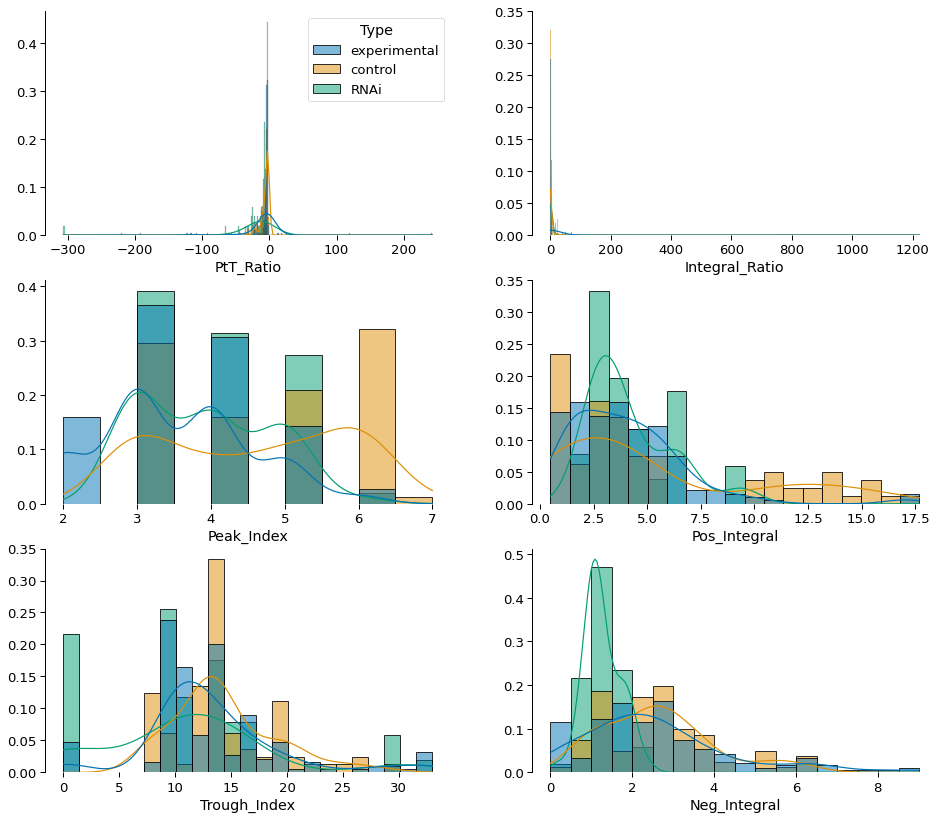

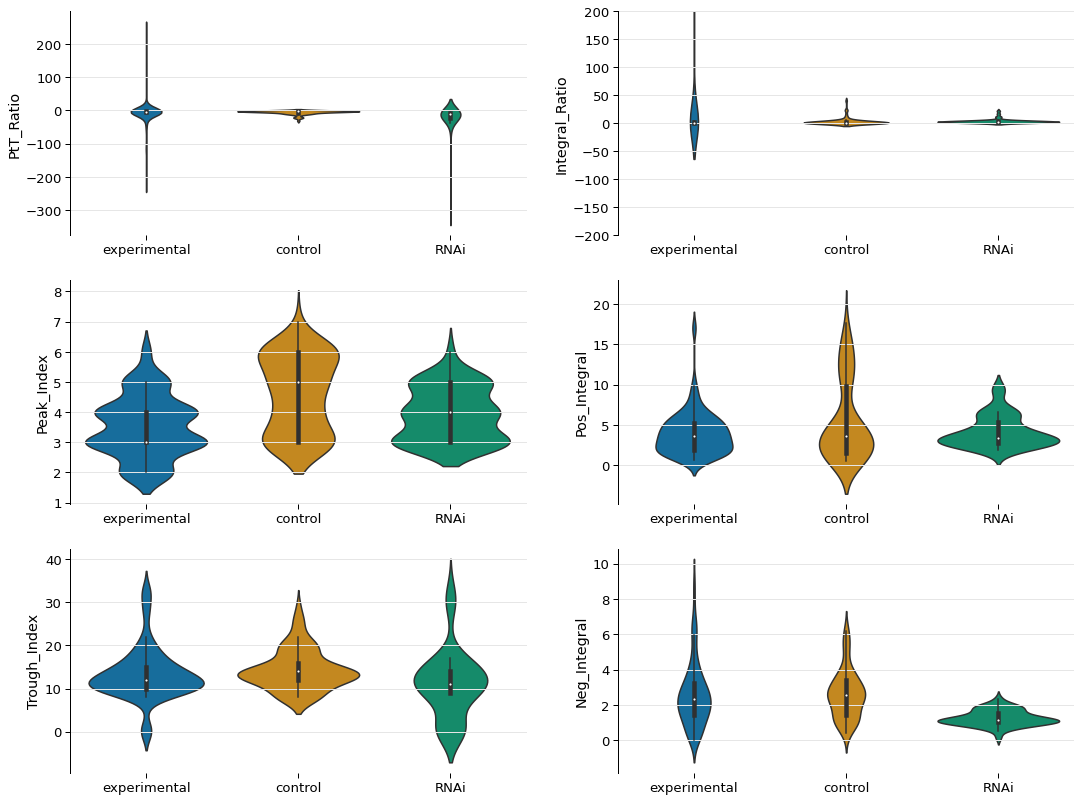

In [153]:
save_fig = False
dv_set = ["PtT_Ratio", "Integral_Ratio", "Peak_Index", "Pos_Integral", "Trough_Index", "Neg_Integral"]

sns.set_context("paper", font_scale=1.5)
hist_figs, hist_axes = plt.subplots(3, 2, figsize=(16, 14))
hist_axes = hist_axes.flatten()
for dv, hist_ax in zip(dv_set, hist_axes):
    sns.histplot(data=prox_win0_df, x=dv, hue='Type', ax=hist_ax, kde=True, stat='probability', common_norm=False, multiple='layer',element="bars", palette='colorblind')
    hist_ax.set_ylabel('')
    sns.despine(fig=hist_figs, top=True, right=True, bottom=True)
# remove legends from all but the first plot
for hist_ax in hist_axes[1:]:
    hist_ax.get_legend().remove()
    
# same but with violinplots
sns.set_context("paper", font_scale=1.5)
viol_figs, viol_axes = plt.subplots(3, 2, figsize=(18, 14))
viol_axes = viol_axes.flatten()
for dv, viol_ax in zip(dv_set, viol_axes):
    sns.violinplot(ax=viol_ax, data=prox_win0_df, x='Type', y=dv, 
        palette='colorblind', orient='v', linewidth=1.5,
        cut=2,
    )

for viol_ax in viol_axes:
    
    viol_ax.grid(axis="y", color="0.9", linestyle="-", linewidth=1)

    sns.despine(fig=viol_figs, top=True, right=True, bottom=True,)
    # remove x-axis label
    viol_ax.set_xlabel('')
# set y limits of subplot 1
viol_axes[1].set_ylim([-200, 200])

if save_fig == True:
    hist_figs.savefig(save_directory + 'histograms_by_type.png', dpi=300, bbox_inches='tight')
    viol_figs.savefig(save_directory + 'violinplots_by_type.png', dpi=300, bbox_inches='tight')

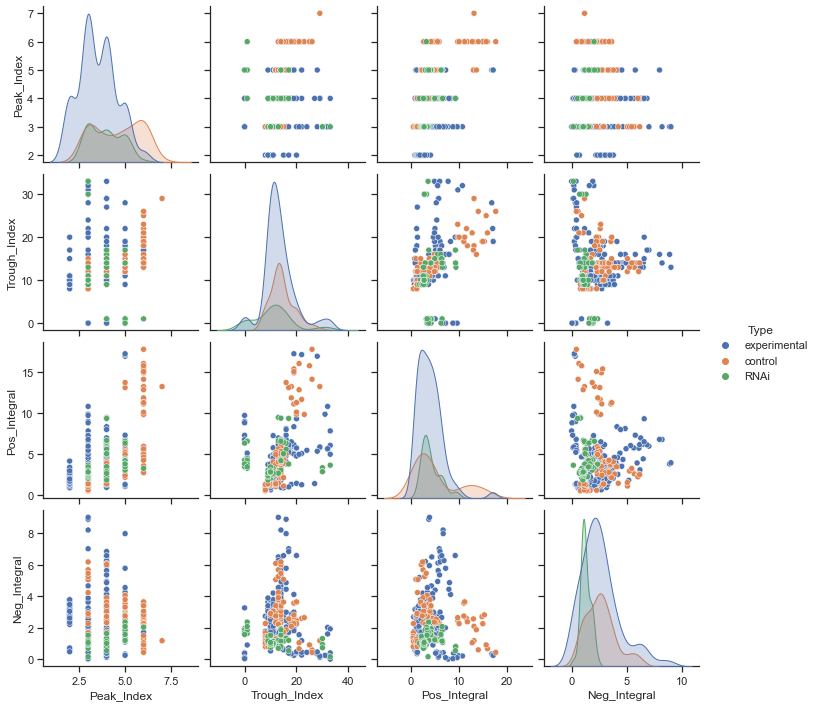

In [154]:
sns.set_theme(style="ticks")

sns.pairplot(
    prox_win0_df, hue="Type", 
    x_vars=["Peak_Index", "Trough_Index", "Pos_Integral", "Neg_Integral"],
    y_vars=["Peak_Index", "Trough_Index", "Pos_Integral", "Neg_Integral"],
    )

Text(0, 0.5, 'Negative Integral')

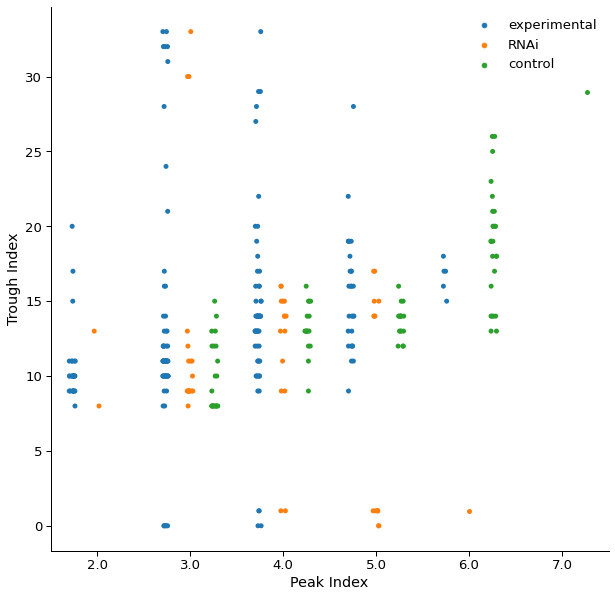

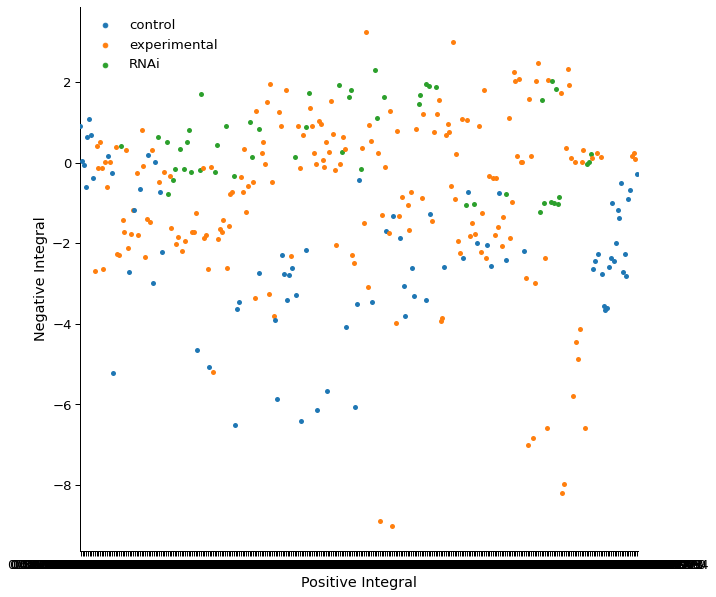

In [100]:
sns.set_context("paper", font_scale=1.5)


pt_fig, pt_ax = plt.subplots(1, figsize=(10, 10))
sns.stripplot(
    data=prox_win0_df, x="Peak_Index", y="Trough_Index", hue="Type", dodge=True
)
pt_ax.legend(title='', frameon=False)
sns.despine(fig=pt_fig, top=True, right=True,)
pt_ax.set_xlabel("Peak Index")
pt_ax.set_ylabel("Trough Index")

# same but with integrals
sns.set_context("paper", font_scale=1.5)
pt_fig, pt_ax = plt.subplots(1, figsize=(10, 10))
sns.stripplot(
    data=prox_win0_df, x="Pos_Integral", y="Neg_Integral", hue="Type", dodge=True
)
pt_ax.legend(title='', frameon=False)
sns.despine(fig=pt_fig, top=True, right=True,)
pt_ax.set_xlabel("Positive Integral")
pt_ax.set_ylabel("Negative Integral")